In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [2]:
# Read data:
series = AirPassengersDataset().load().astype(np.float32)

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp("19590101"))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
# Change name
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)
train_scaled

<TimeSeries (DataArray) (Month: 121, component: 1, sample: 1)>
array([[[0.01995012]],

       [[0.03491271]],

       [[0.06982544]],

       [[0.06234413]],

       [[0.04239401]],

       [[0.07730672]],

       [[0.10972568]],

       [[0.10972568]],

       [[0.07980049]],

       [[0.03740647]],

...

       [[0.6084788 ]],

       [[0.64588535]],

       [[0.8254365 ]],

       [[0.9650873 ]],

       [[1.        ]],

       [[0.7481297 ]],

       [[0.6359103 ]],

       [[0.51371574]],

       [[0.5810474 ]],

       [[0.638404  ]]], dtype=float32)
Coordinates:
  * Month      (Month) datetime64[ns] 1949-01-01 1949-02-01 ... 1959-01-01
  * component  (component) object '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [3]:
my_model = TransformerModel(
    pl_trainer_kwargs={"accelerator": "gpu", "devices": [0]},
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=200,
    model_name="air_transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

my_model

In [4]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 4it [00:00, ?it/s]

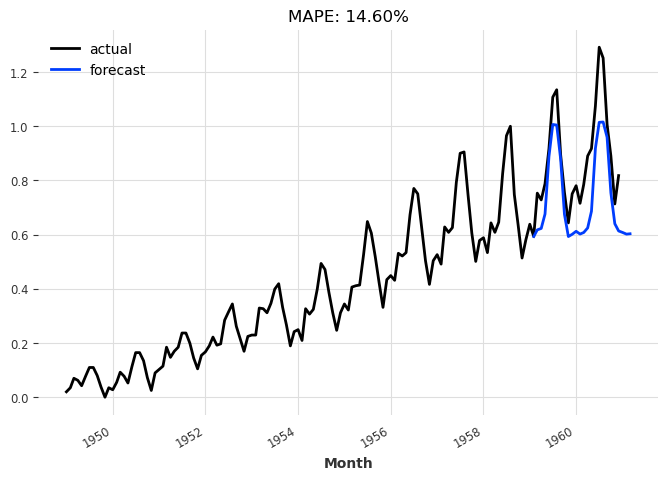

In [9]:
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


eval_model(my_model, 26, series_scaled, val_scaled)

Predicting: 0it [00:00, ?it/s]

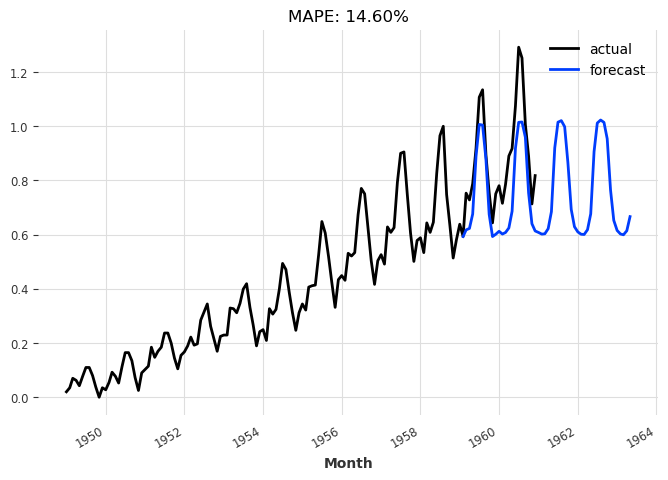

In [10]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="air_transformer", best=True
)
eval_model(best_model, 52, series_scaled, val_scaled)